# Driver behavior detection (DNN)

In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Import data

Data set from https://data.mendeley.com/datasets/jj3tw8kj6h/2

In [4]:
df = pd.read_csv('Driving Behavior Dataset/Features By Window Size/features_14.csv')

In [5]:
df.head()

,Target,AccMeanX,AccMeanY,AccMeanZ,AccCovX,AccCovY,AccCovZ,AccSkewX,AccSkewY,AccSkewZ,...,GyroMaxZ,GyroVarX,GyroVarY,GyroVarZ,GyroMedianX,GyroMedianY,GyroMedianZ,GyroStdX,GyroStdY,GyroStdZ
0,1,0.285339,-0.138611,-0.957764,0.022150,0.003975,0.001926,0.867594,-1.305868,-0.507254,...,0.832061,0.761120,0.184372,0.262859,-0.286260,4.251908,0.706107,0.872422,0.429385,0.512697
1,1,0.313477,-0.161670,-0.956250,0.020571,0.005640,0.001456,0.002474,-0.395088,-0.677572,...,0.832061,3.061080,0.585991,0.270340,0.335878,3.969466,0.587786,1.749594,0.765501,0.519942
2,1,0.325195,-0.158325,-0.950155,0.017281,0.004579,0.001388,-0.354212,-0.603657,-0.984635,...,0.832061,3.137076,0.552431,0.905518,-0.286260,3.832061,0.240458,1.771179,0.743257,0.951587
3,1,0.336565,-0.172468,-0.937640,0.015305,0.005216,0.002253,-0.655653,-0.152454,-0.040530,...,0.832061,2.809524,3.963056,0.893127,0.335878,3.969466,-0.106870,1.676163,1.990743,0.945054
4,1,0.337860,-0.164185,-0.941681,0.013132,0.005020,0.002062,-0.718488,-0.446061,0.250539,...,0.832061,2.667567,3.414394,0.799787,-0.286260,4.038168,-0.179389,1.633269,1.847808,0.894308


## Clean dataset

There are no empty values present in the dataset, thus no cleaning is required. To ease the integration of the Deep Neural Network (DNN), I adjusted the target variable range from 0 to 3, instead of 1 to 4.

In [6]:
df.isna().sum()

Target         0
AccMeanX       0
AccMeanY       0
AccMeanZ       0
AccCovX        0
              ..
GyroMedianY    0
GyroMedianZ    0
GyroStdX       0
GyroStdY       0
GyroStdZ       0
Length: 61, dtype: int64

In [7]:
df[df.isna().sum(axis=1) > 0]

,Target,AccMeanX,AccMeanY,AccMeanZ,AccCovX,AccCovY,AccCovZ,AccSkewX,AccSkewY,AccSkewZ,...,GyroMaxZ,GyroVarX,GyroVarY,GyroVarZ,GyroMedianX,GyroMedianY,GyroMedianZ,GyroStdX,GyroStdY,GyroStdZ


In [8]:
df['Target'] -= 1

## Discover variables

In [9]:
df['Target'].value_counts()

Target
2    347
1    285
0    249
3    221
Name: count, dtype: int64

There are also 60 features in the dataset representing accelerometer (X,Y,Z axis in meters per second squared (m/s2)) and gyroscope (X,Y, Z axis in degrees per second (°/s) )

In [68]:
features_only_df = df.drop(columns=['Target'])

summary_stats = features_only_df.describe()

summary_stats = summary_stats.transpose()

summary_stats

,count,mean,std,min,25%,50%,75%,max
AccMeanX,1102.0,0.250681,0.080183,0.019642,0.196429,0.254752,0.309457,0.445452
AccMeanY,1102.0,-0.094582,0.091875,-0.309535,-0.166037,-0.114406,-0.007616,0.114851
AccMeanZ,1102.0,-0.983306,0.026849,-1.053659,-1.003257,-0.984262,-0.964587,-0.900652
AccCovX,1102.0,0.029196,0.022935,0.000042,0.012777,0.022769,0.034529,0.109354
AccCovY,1102.0,0.030323,0.022036,0.000070,0.007605,0.031239,0.045968,0.094144
AccCovZ,1102.0,0.009583,0.006485,0.000118,0.004619,0.008100,0.012561,0.030886
AccSkewX,1102.0,-0.112822,0.698375,-2.694572,-0.558205,-0.135493,0.205514,3.321394
AccSkewY,1102.0,-0.099898,1.056449,-3.429108,-0.866926,-0.123392,0.774952,2.504595
AccSkewZ,1102.0,-0.186448,0.892163,-3.073868,-0.781039,-0.124783,0.350263,3.356136
AccKurtX,1102.0,-0.425800,1.732597,-5.683040,-1.455117,-0.885571,0.125803,11.463292


## Choice of features

In [32]:
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix['Target'].abs().sort_values(ascending=False)
correlation_with_target

Target        1.000000
AccMeanY      0.454897
AccSumY       0.446240
AccMedianY    0.429385
AccMaxY       0.416900
                ...   
GyroVarZ      0.030372
AccMinX       0.028903
AccKurtX      0.027165
GyroSkewY     0.024652
AccSkewZ      0.014248
Name: Target, Length: 61, dtype: float64

In [33]:
top_features = correlation_with_target.index.tolist()
df_selected_features = df[top_features]
df_selected_features

,Target,AccMeanY,AccSumY,AccMedianY,AccMaxY,AccStdZ,AccStdY,GyroSkewZ,AccMaxZ,AccCovZ,...,AccSumZ,GyroStdZ,AccSumX,GyroKurtX,GyroCovZ,GyroVarZ,AccMinX,AccKurtX,GyroSkewY,AccSkewZ
0,0,-0.138611,-0.554443,-0.120483,-0.086670,0.043889,0.063049,-1.727183,-0.911621,0.001926,...,-3.831055,0.512697,1.141357,-4.710496,0.262859,0.262859,0.162598,-1.164806,-0.338028,-0.507254
1,0,-0.161670,-0.808350,-0.140381,-0.086670,0.038159,0.075100,-0.501530,-0.911621,0.001456,...,-4.781250,0.519942,1.567383,1.633018,0.270340,0.270340,0.162598,-2.649441,-1.069372,-0.677572
2,0,-0.158325,-0.949951,-0.140991,-0.086670,0.037253,0.067669,-1.302740,-0.911621,0.001388,...,-5.700928,0.951587,1.951172,1.663170,0.905518,0.905518,0.162598,-1.819232,-0.378864,-0.984635
3,0,-0.172468,-1.207275,-0.141602,-0.086670,0.047465,0.072222,-0.667798,-0.862549,0.002253,...,-6.563477,0.945054,2.355957,0.434190,0.893127,0.893127,0.162598,-1.214712,2.009707,-0.040530
4,0,-0.164185,-1.313477,-0.140991,-0.086670,0.045406,0.070850,-0.388248,-0.862549,0.002062,...,-7.533447,0.894308,2.702881,0.737750,0.799787,0.799787,0.162598,-0.666622,2.151158,0.250539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,3,-0.094552,-1.323730,-0.020508,0.144775,0.050875,0.185546,2.981735,-0.873535,0.002588,...,-13.775146,2.207612,3.825195,1.180110,4.873553,4.873553,-0.007568,-1.655437,-0.353603,0.529063
1098,3,-0.092791,-1.299072,-0.020508,0.144775,0.043778,0.184051,3.516031,-0.873535,0.001917,...,-13.667725,2.134740,3.705566,1.954504,4.557117,4.557117,-0.007568,-1.515821,-0.821955,1.008758
1099,3,-0.091030,-1.274414,-0.020508,0.144775,0.043621,0.182879,3.534109,-0.873535,0.001903,...,-13.664551,2.137460,3.599365,2.076821,4.568735,4.568735,-0.007568,-1.295757,-0.794679,1.009590
1100,3,-0.091047,-1.274658,-0.020508,0.144775,0.045317,0.182879,3.523304,-0.873535,0.002054,...,-13.698242,2.145522,3.599854,2.017343,4.603264,4.603264,-0.007568,-1.296626,-0.840853,0.987714


## Implement the Deep Neural Network (DNN)

In [34]:
X = df[top_features].drop(columns=['Target'])
y = df['Target']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [85]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')  # 4 classes for targets
])

In [86]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [87]:
early_stopper = EarlyStopping(patience=10, restore_best_weights=True)

model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopper])

Epoch 1/100
28/28 [==============================] - 1s 6ms/step - loss: 1.2121 - accuracy: 0.4916 - val_loss: 0.7603 - val_accuracy: 0.8900
Epoch 2/100
28/28 [==============================] - 0s 3ms/step - loss: 0.6781 - accuracy: 0.8002 - val_loss: 0.3608 - val_accuracy: 0.9100
Epoch 3/100
28/28 [==============================] - 0s 3ms/step - loss: 0.4192 - accuracy: 0.8799 - val_loss: 0.2190 - val_accuracy: 0.9100
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2790 - accuracy: 0.9147 - val_loss: 0.1385 - val_accuracy: 0.9300
Epoch 5/100
28/28 [==============================] - 0s 3ms/step - loss: 0.2082 - accuracy: 0.9304 - val_loss: 0.1041 - val_accuracy: 0.9800
Epoch 6/100
28/28 [==============================] - 0s 3ms/step - loss: 0.1687 - accuracy: 0.9473 - val_loss: 0.0863 - val_accuracy: 0.9800
Epoch 7/100
28/28 [==============================] - 0s 3ms/step - loss: 0.1406 - accuracy: 0.9540 - val_loss: 0.0790 - val_accuracy: 0.9800
Epoch 8/100
2

## Evaluate the model

In [88]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

4/4 [==============================] - 0s 2ms/step
Accuracy: 0.7477477477477478
Precision: 0.5960771276595744
Recall: 0.702922077922078
F1-score: 0.6260545100584036


/home/cytech/Cours/ING3/Ouverture/TP1/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


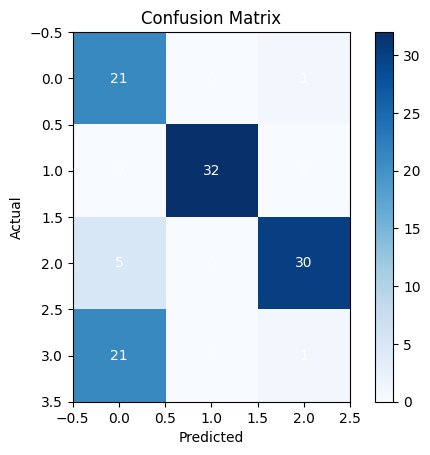

In [93]:
import matplotlib.pyplot as plt

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
plt.imshow(confusion_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Print the number in each cell
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, confusion_matrix.iloc[i, j], ha='center', va='center', color='white')

plt.show()

The model never predict class 3 (Sudden Break)